In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import eqs_magnetics as eqs
import harmonica as hm
import itertools
import xarray as xr
import synthetics
import warnings

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
icegrav = pd.read_csv('/home/jupyter-india/data-for-eqs-gb-norm-of-b/icegrav.csv', header=0)
coordinates = [icegrav.x, icegrav.y, icegrav.Height_WGS1984]
field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 30)]).T

In [4]:
grid_spacing = 5e3
region = vd.get_region(coordinates)
grid_coordinates = vd.grid_coordinates(region, spacing=grid_spacing, extra_coords=3e3)
mask = vd.distance_mask(data_coordinates=coordinates, maxdist=28e3, coordinates=grid_coordinates)
grid_coords_masked = (
    np.array((xr.DataArray(grid_coordinates[0])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[1])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[2])).where(mask, drop=False))
)
coordinates_km = [coord / 1000 for coord in coordinates]
grid_coordinates_km = [coord / 1000 for coord in grid_coordinates]

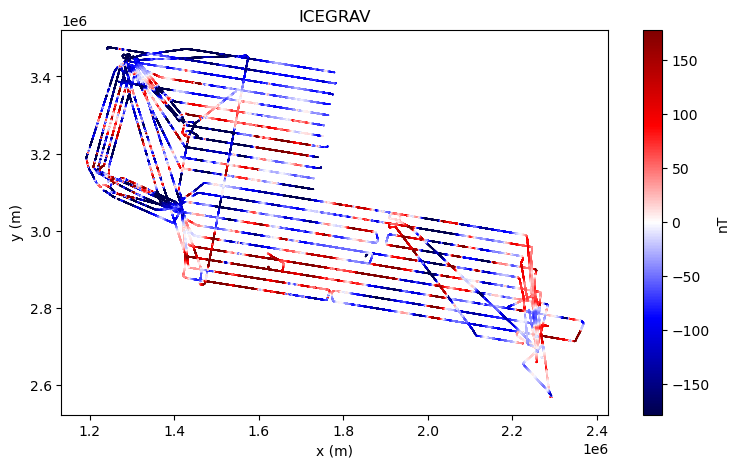

In [5]:
plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
scale_icegrav = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(
    *coordinates[:2],
    c=icegrav.MagL,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav)
plt.title("ICEGRAV")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
plt.show()

## Fit Deep sources

In [6]:
block_spacing = 15e3
reducer = vd.BlockReduce(
    reduction=np.median,
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.3)),
    drop_coords=False
)
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=icegrav.MagL)

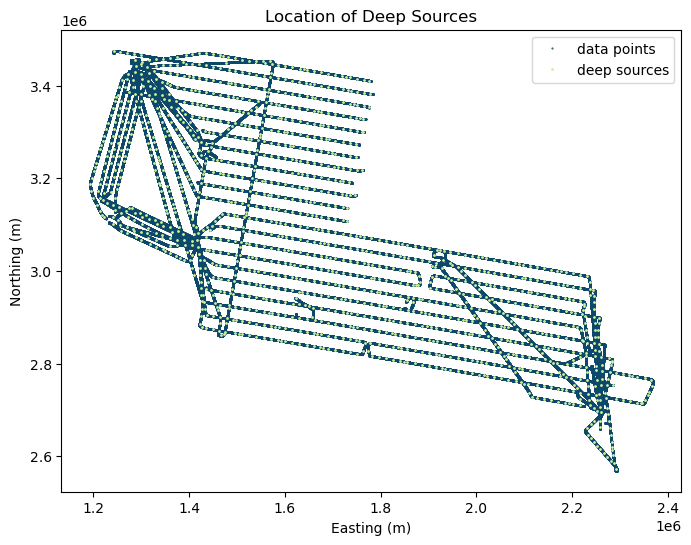

In [7]:
plt.figure(figsize=(8,6))
plt.plot(*coordinates[:2], ".", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], ".", color="#cff09e", markersize=2, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

In [8]:
spacing = np.mean(vd.median_distance(coords_blocked))
depths_deep = [spacing*2.5, spacing*3, spacing*3.5, spacing*4, spacing*4.5, spacing*5, spacing*5.5, spacing*6]
dampings_deep = [1e0, 1e1, 1e2, 1e3, 1e4]

In [9]:
parameter_sets_deep = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep, depths_deep)
]
print("Number of combinations:", len(parameter_sets_deep))

Number of combinations: 40


In [10]:
%%time
kfold = vd.BlockKFold(
    spacing=200e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores_deep = []
damping_deep = []
source_depth_deep = []
for parameters in parameter_sets_deep:    
    eqs_deep = eqs.EquivalentSourcesMagnetic(**parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.sqrt(np.nanmean((tfa_blocked[test] - predicted)**2)))
    scores_deep.append(np.mean(tmp))
    damping_deep.append(parameters['damping'])
    source_depth_deep.append(parameters['depth'])

CPU times: user 7min 52s, sys: 4min 54s, total: 12min 47s
Wall time: 22.7 s


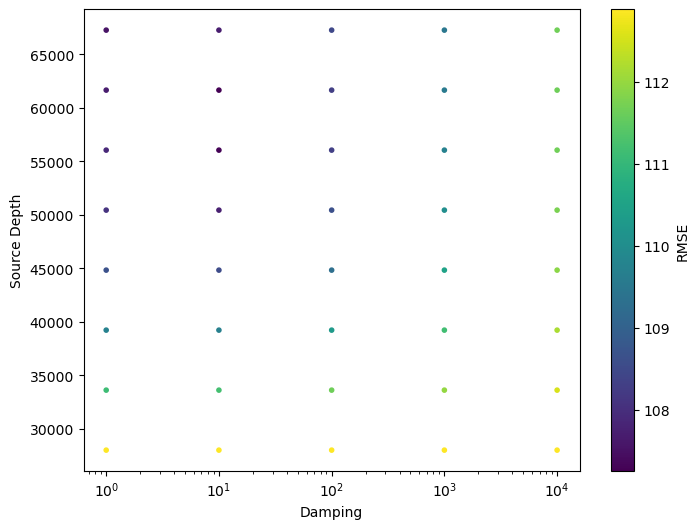

{'damping': 10.0, 'depth': 61655.31240177877}

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(
    damping_deep,
    source_depth_deep,
    c=scores_deep,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores_deep,90),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='RMSE')
plt.show()

best_deep = np.argmin(scores_deep)
parameter_sets_deep[best_deep]

In [12]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets_deep[best_deep])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = icegrav.MagL - tfa_deep

source height: -58768.41240177877
CPU times: user 15.2 s, sys: 2.13 s, total: 17.4 s
Wall time: 542 ms


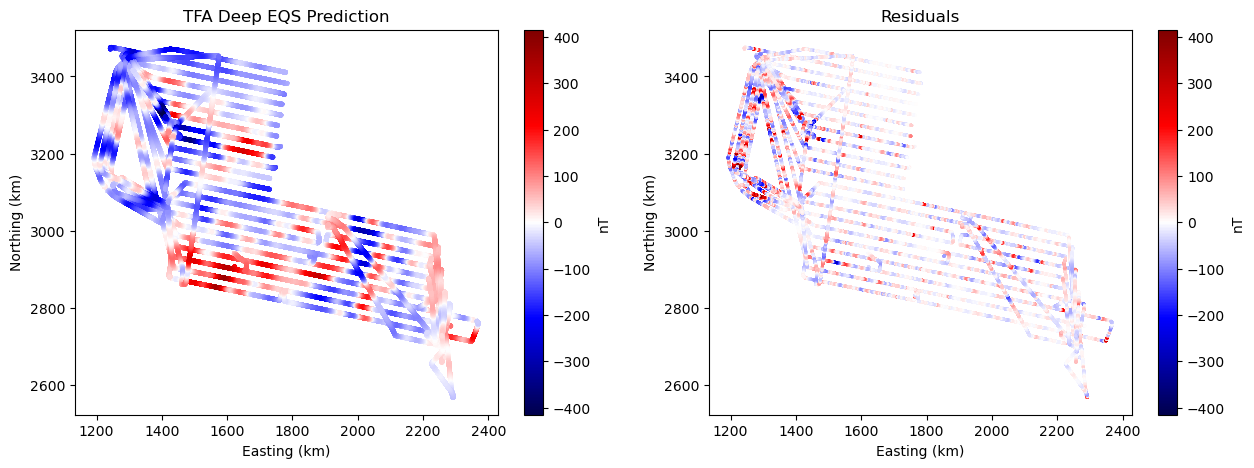

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
scale = vd.maxabs(tfa_deep)
plt.scatter(*coordinates_km[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("Easting (km)")
plt.ylabel("Northing (km)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
#scale = vd.maxabs(tfa_residuals)
plt.scatter(*coordinates_km[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (km)")
plt.ylabel("Northing (km)")
plt.colorbar(label="nT")
plt.show()

## Fit deep residuals with shallow GB-EQS

In [17]:
window_size = 400e3
dampings_shallow = [1e0, 1e1, 1e2, 1e3, 1e4]
depths_shallow = [6e3, 7e3, 8e3, 9e3, 10e3]

parameter_sets_shallow = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_shallow, depths_shallow)
]
print("Number of combinations:", len(parameter_sets_shallow))

Number of combinations: 25


In [18]:
%%time
kfold = vd.BlockKFold(
    spacing=20e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores_shallow = []
damping_shallow = []
source_depth_shallow = []
for parameters in parameter_sets_shallow:    
    print(parameters)
    tmp = []
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(
            random_state=0,
            block_size=grid_spacing,
            window_size=window_size,
            damping=parameters['damping'],
            depth=parameters['depth'],
    )
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train],
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.sqrt(np.nanmean((tfa_residuals[test] - predicted)**2)))
    scores_shallow.append(np.mean(tmp))
    damping_shallow.append(parameters['damping'])
    source_depth_shallow.append(parameters['depth'])

{'damping': 1.0, 'depth': 6000.0}
{'damping': 1.0, 'depth': 7000.0}
{'damping': 1.0, 'depth': 8000.0}
{'damping': 1.0, 'depth': 9000.0}
{'damping': 1.0, 'depth': 10000.0}
{'damping': 10.0, 'depth': 6000.0}
{'damping': 10.0, 'depth': 7000.0}
{'damping': 10.0, 'depth': 8000.0}
{'damping': 10.0, 'depth': 9000.0}
{'damping': 10.0, 'depth': 10000.0}
{'damping': 100.0, 'depth': 6000.0}
{'damping': 100.0, 'depth': 7000.0}
{'damping': 100.0, 'depth': 8000.0}
{'damping': 100.0, 'depth': 9000.0}
{'damping': 100.0, 'depth': 10000.0}
{'damping': 1000.0, 'depth': 6000.0}
{'damping': 1000.0, 'depth': 7000.0}
{'damping': 1000.0, 'depth': 8000.0}
{'damping': 1000.0, 'depth': 9000.0}
{'damping': 1000.0, 'depth': 10000.0}
{'damping': 10000.0, 'depth': 6000.0}
{'damping': 10000.0, 'depth': 7000.0}
{'damping': 10000.0, 'depth': 8000.0}
{'damping': 10000.0, 'depth': 9000.0}
{'damping': 10000.0, 'depth': 10000.0}
CPU times: user 6h 42min 2s, sys: 56min 46s, total: 7h 38min 49s
Wall time: 1h 8min 54s


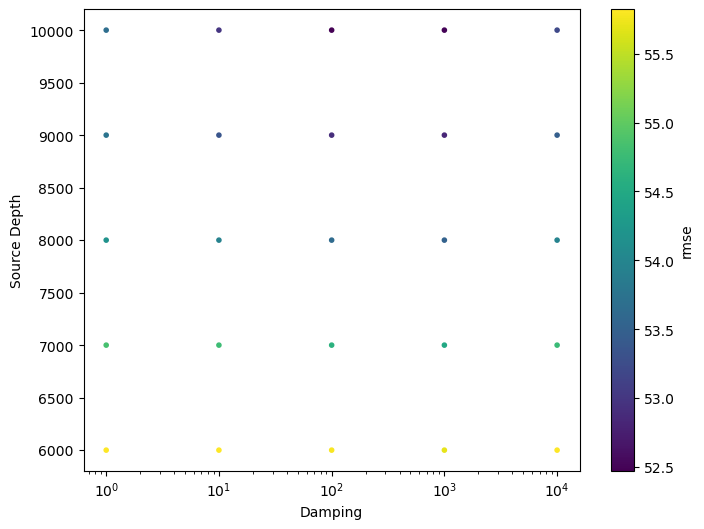

{'damping': 100.0, 'depth': 10000.0}

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(
    damping_shallow,
    source_depth_shallow,
    c=scores_shallow,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores_shallow,95),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

best_shallow = np.argmin(scores_shallow)
parameter_sets_shallow[best_shallow]

In [20]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_size,
    damping=parameter_sets_shallow[best_shallow]['damping'],
    depth=parameter_sets_shallow[best_shallow]['depth'],
    repeat=2,
)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)

CPU times: user 8min 43s, sys: 1min 5s, total: 9min 48s
Wall time: 1min 41s


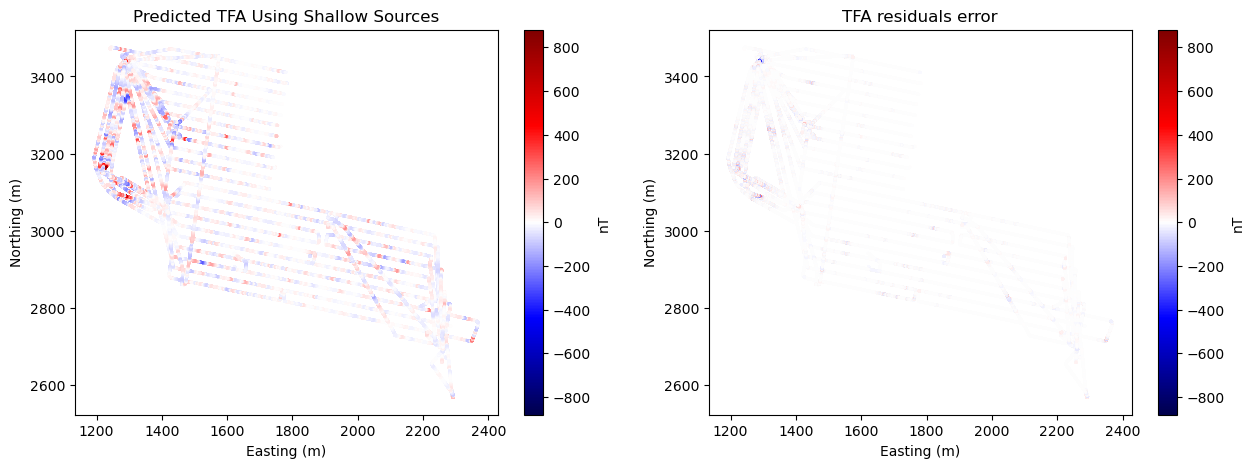

In [21]:
tfa_shallow_predicted = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)
error_shallow_predicted = tfa_residuals - tfa_shallow_predicted

plt.figure(figsize=(15,5))
scale_shallow_predicted = vd.maxabs(tfa_shallow_predicted)
plt.subplot(1,2,1)
plt.scatter(*coordinates_km[:2], c=tfa_shallow_predicted, cmap="seismic", s=1, vmin=-scale_shallow_predicted, vmax=scale_shallow_predicted)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates_km[:2], c=error_shallow_predicted, cmap="seismic", s=1, vmin=-scale_shallow_predicted, vmax=scale_shallow_predicted)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Prediction

In [22]:
predicted_b = eqs_deep.predict(coordinates) + eqs_shallow.predict(coordinates)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = icegrav.MagL - predicted_tfa
rmse_tfa = np.sqrt(np.nanmean((error_tfa)**2))
nrmse_tfa = rmse_tfa / (np.nanmax(icegrav.MagL) - np.nanmin(icegrav.MagL))

predicted_b_grid = eqs_deep.predict(grid_coords_masked) + eqs_shallow.predict(grid_coords_masked)
predicted_tfa_grid = eqs.total_field_anomaly(predicted_b_grid, field_direction)
predicted_bnorm_grid = np.sqrt(sum(c**2 for c in predicted_b_grid))

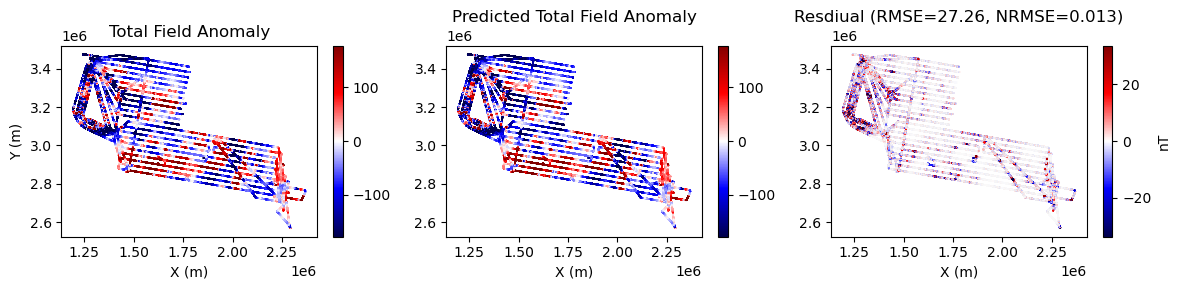

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
plot1 = ax[0].scatter(
    *coordinates[:2],
    c=icegrav.MagL,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav,
)
ax[0].set_title("Total Field Anomaly")
ax[0].set_ylabel("Y (m)")
ax[0].set_xlabel("X (m)")
fig.colorbar(plot1, ax=ax[0])

plot2 = ax[1].scatter(
    *coordinates[:2],
    c=predicted_tfa,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav,
)
ax[1].set_title("Predicted Total Field Anomaly")
ax[1].set_xlabel("X (m)")
fig.colorbar(plot2, ax=ax[1])

scale_error_tfa = vd.maxabs(error_tfa) 
scale_error_tfa = np.nanpercentile(error_tfa, 99)
plot3 = ax[2].scatter(
    *coordinates[:2],
    c=error_tfa,
    cmap="seismic",
    s=0.01,
    vmin=-scale_error_tfa,
    vmax=scale_error_tfa,
)
ax[2].set_title(f'Resdiual (RMSE={np.round(rmse_tfa,2)}, NRMSE={np.round(nrmse_tfa, 3)})')
ax[2].set_xlabel("X (m)")
fig.colorbar(plot3, ax=ax[2], label="nT")

fig.tight_layout()
fig.show()

In [24]:
import matplotlib.colors as mcolors
# Define a custom colormap similar to the red portion of the seismic colour scheme for the norm of b figures.
colours = [(1, 1, 1), (1, 0.3, 0.3), (1, 0, 0), (0.5, 0, 0)]  # White -> bright light red -> bright red -> dark red
n_bins = 100  
red_cm = mcolors.LinearSegmentedColormap.from_list("white_to_red", colours, N=n_bins)
red_norm = mcolors.Normalize(vmin=0, vmax=np.nanpercentile(predicted_bnorm_grid, 99))# Normalise with the bnorm range

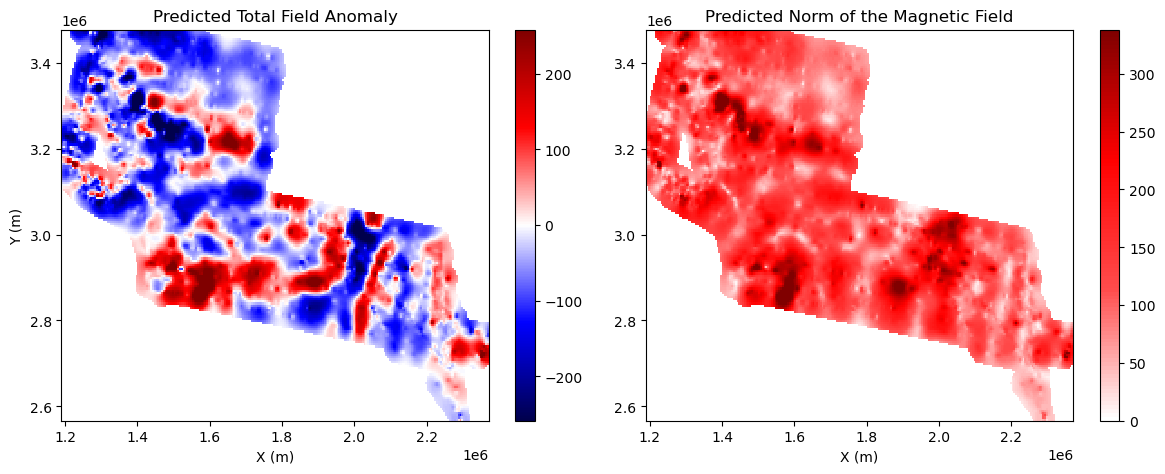

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
#scale_predicted_tfa_grid = vd.maxabs(predicted_tfa_grid)
scale_predicted_tfa_grid = np.nanpercentile(predicted_tfa_grid, 99)
plot1 = ax[0].pcolormesh(
    *grid_coordinates[:2],
    predicted_tfa_grid,
    #cmap="jet",#"seismic",
    cmap="seismic",    
    vmin=-scale_predicted_tfa_grid,
    vmax=scale_predicted_tfa_grid,
)
ax[0].set_title("Predicted Total Field Anomaly")
ax[0].set_xlabel("X (m)")
ax[0].set_ylabel("Y (m)")
fig.colorbar(plot1, ax=ax[0])

plot2 = ax[1].pcolormesh(
    *grid_coordinates[:2],
    predicted_bnorm_grid,
    cmap=red_cm,
    norm=red_norm,
)
ax[1].set_title("Predicted Norm of the Magnetic Field")
ax[1].set_xlabel("X (m)")
fig.colorbar(plot2, ax=ax[1])

fig.tight_layout()
fig.show()